In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 08b
## Introduction to Pytorch
- one hidden layer 
- ${tanh}$ activation function
- multi-class output
- FIFA dataset 

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
import os
#import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
# Some basic parameters
inpDir = '../../input'
outDir = '../output'

RANDOM_STATE = 24
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 2001 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.Spectral

plt.rcParams.update(params)

In [4]:
# tf.keras.layers.Dense(
#     units,
#     activation=None,
#     use_bias=True,
#     kernel_initializer='glorot_uniform',
#     bias_initializer='zeros',
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     lora_rank=None,
#     **kwargs
# )

## Helper Function
* Import from util.helper

In [5]:
###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [6]:

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

## Read FIFA 2019 data set
<img src = '../../images/fifa_2019.png' alt = 'Fifa 2019'>

In [7]:
data_df = pd.read_csv('fifa_2019.csv')
data_df.shape

(18207, 89)

In [8]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [9]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [10]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [11]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [12]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [13]:
class_labels = {0: 'GK', 1: 'Defender', 2: 'Mid Fielder', 3 : 'Forward'}

In [14]:
y = data_df["Position"].to_numpy()

X = data_df.drop("Position", axis = 1)

X.shape, y.shape

((18147, 33), (18147,))

In [15]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517,) (3630, 33) (3630,)


In [16]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [17]:
torch.cuda.is_available()

False

In [18]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [21]:
input_dim = X_train.shape[1]

model = nn.Sequential(
    nn.Linear(input_dim, 18),
    nn.Tanh(),
    nn.Linear(18, 4)
).to(device=device)

In [22]:
print(model)

Sequential(
  (0): Linear(in_features=33, out_features=18, bias=True)
  (1): Tanh()
  (2): Linear(in_features=18, out_features=4, bias=True)
)


In [24]:
list(model.parameters())

[Parameter containing:
 tensor([[-1.4253e-01,  2.1556e-02, -1.0044e-01, -7.8503e-02, -4.2497e-02,
          -3.4477e-02, -1.7216e-01, -2.0478e-02,  4.1106e-03,  1.7127e-01,
           1.4059e-01, -4.6002e-02,  2.7917e-02,  1.0391e-01, -1.0599e-01,
           4.4086e-02, -1.0842e-01,  8.9580e-02,  3.6711e-02, -1.4122e-01,
           3.1820e-02,  4.2726e-02, -4.1416e-02,  1.0838e-01, -6.3052e-02,
           9.5651e-02,  1.5665e-01, -1.4495e-01, -8.4502e-02, -4.8101e-02,
           1.4130e-01,  6.2851e-02, -7.8314e-02],
         [ 1.1581e-01,  2.6211e-02,  1.0844e-01, -5.1324e-02,  7.7092e-02,
          -4.2449e-02, -2.4985e-02,  1.4519e-01,  8.8288e-02, -4.2670e-03,
           5.7873e-02,  2.3301e-03,  1.6991e-01, -1.4679e-01, -2.0034e-02,
          -6.8924e-02,  1.1426e-01, -9.7242e-02, -8.3086e-03, -1.2953e-01,
          -8.7781e-02, -7.1128e-02,  5.5708e-02, -1.1116e-01,  1.1029e-02,
           1.4299e-01, -1.4401e-01,  2.7557e-02, -5.6052e-02, -5.4366e-02,
          -5.0664e-02, -1.7

In [25]:
print (f'Num Parameters: {len(list(model.parameters()))}')  
print (f'Layer 1: Weights : {list(model.parameters())[0].shape}')
print (f'Layer 1: Bias    : {list(model.parameters())[1].shape}')
print (f'Layer 2: Weights : {list(model.parameters())[2].shape}')
print (f'Layer 2: Bias    : {list(model.parameters())[3].shape}')

Num Parameters: 4
Layer 1: Weights : torch.Size([18, 33])
Layer 1: Bias    : torch.Size([18])
Layer 2: Weights : torch.Size([4, 18])
Layer 2: Bias    : torch.Size([4])


In [26]:
train_X = torch.tensor(X_train, dtype=torch.float32, device=device)
train_y = torch.tensor(y_train, dtype=torch.int64, device=device)

test_X = torch.tensor(X_test, dtype=torch.float32, device=device)
test_y = torch.tensor(y_test, dtype=torch.int64, device=device)


In [27]:
train_X[:1].shape, train_X[0].shape

(torch.Size([1, 33]), torch.Size([33]))

# Making predictions

In [30]:
predict_prob = model(train_X[:1])  # make predictions
predict_prob.detach().cpu().numpy()

array([[-0.4829939 , -0.17291737,  0.1093571 , -0.16629228]],
      dtype=float32)

In [31]:
y_train[0]

3

In [32]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Iterations
for epoch in range (EPOCHS):
    
    model.train() # Set the model in training mode
    
    predict_prob = model(train_X) # make predictions
    
    curr_loss = loss_fn(predict_prob, train_y) # calculate loss

    ###---------------
    ### Back prop step
    ###---------------
    optimizer.zero_grad() 
    curr_loss.backward()
    optimizer.step()

In [33]:
# Lets see prediction for first row
predict_prob = model(train_X[:1]) # make predictions 
predict_prob.detach().cpu().numpy()

array([[-1.6963881, -5.650289 ,  1.5146383,  4.750081 ]], dtype=float32)

In [34]:
predict_prob.argmax().item(), train_y[0].item()

(3, 3)

In [36]:

del model

model = nn.Sequential(
    nn.Linear( input_dim, 18),
    nn.Tanh(),
    nn.Linear( 18, 4)
).to(device=device)

In [37]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Some lists to collect data
loss = []
tloss = []
n_epoch = []
acc = []
tacc = []

# Iterations
for epoch in range (EPOCHS):
    
    model.train() # Set the model in training mode
    
    predict_prob = model(train_X) # make predictions
    
    curr_loss = loss_fn(predict_prob, train_y) # calculate loss

    ###---------------
    ### Back prop step
    ###---------------
    optimizer.zero_grad() 
    curr_loss.backward()
    optimizer.step()
    
    loss.append ( curr_loss.data.item() ) # append to loss list
    
    _, y_pred = torch.max(predict_prob, 1) # get predicted class from the probabilities
        
    curr_acc = accuracy_score( y_train, y_pred.data.cpu()) # move to CPU 
    
    acc.append(curr_acc) # append to accuracy list
    
    model.eval() # evaluation mode, prevent from learning
    
    predict_prob_tst = model(test_X) # make predictions on test data
    
    tcurr_loss = loss_fn( predict_prob_tst, test_y)
    
    tloss.append( tcurr_loss.data.item())  # append to loss list
    
    _, y_pred = torch.max(predict_prob_tst, 1) # get predicted class from the probabilities
    
    tcurr_acc = accuracy_score( y_test, y_pred.data.cpu()) # move to CPU 
    
    tacc.append(tcurr_acc) # append to accuracy list
    
    n_epoch.append(epoch)
    
        
    if epoch % 1000 == 0:
        fmtStr = 'Epoch :{:5d}/{:5d} --- Loss: {:.5f}/{:.5f} | Acc {:.5f}/{:.5f}'
        
        print (fmtStr.format(epoch, EPOCHS,
                             curr_loss.data.item(),
                             tcurr_loss.data.item(),  
                             curr_acc, 
                             tcurr_acc))

Epoch :    0/ 2001 --- Loss: 1.42693/1.41269 | Acc 0.20163/0.21377
Epoch : 1000/ 2001 --- Loss: 0.29368/0.30328 | Acc 0.88028/0.87355
Epoch : 2000/ 2001 --- Loss: 0.27283/0.29099 | Acc 0.88827/0.88264


In [38]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : tloss,
                       'acc' : acc,
                       'test_acc': tacc})

In [39]:
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.426926,1.412693,0.201626,0.213774
1,1,1.411307,1.397248,0.215058,0.225344
2,2,1.395972,1.382062,0.228077,0.236364
3,3,1.380899,1.367126,0.241372,0.247934
4,4,1.366074,1.352432,0.255631,0.262259


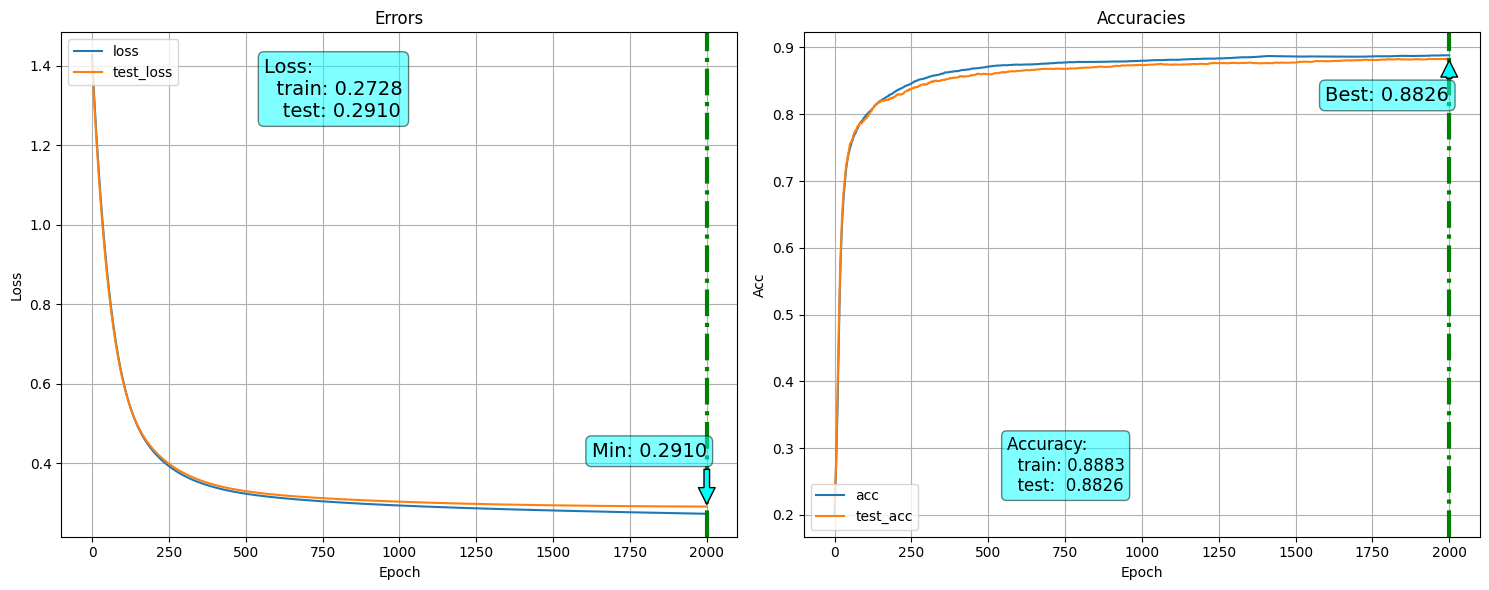

In [40]:
fn_plot_torch_hist(loss_df)